<a href="https://colab.research.google.com/github/BhekiMabheka/Explore/blob/main/How_Probability_Calibration_Works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How Probability Calibration Works

Probability calibration is the process of calibrating an ML model to return the true likelihood of an event. This is necessary when we need the probability of the event in question rather than its classification.

In [2]:
# Create dataset of classification task with many redundant and few informative features

import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import *
np.random.seed(0)

X, y = datasets.make_classification(n_samples=100000, n_features=20, n_informative=2, n_redundant=2)

train_samples = 100
X_train = X[:train_samples]
X_test  = X[train_samples:]
y_train = y[:train_samples]
y_test  = y[train_samples:]

model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
y_pred_rfc = model_rfc.predict(X_test)

print('Random Forest Classification Report:')
print(classification_report(y_true = y_test, y_pred = y_pred_rfc))

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print('Logistic Regression Classification Report:')
print(classification_report(y_true = y_test, y_pred = y_pred_lr))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88     49904
           1       0.85      0.92      0.89     49996

    accuracy                           0.88     99900
   macro avg       0.88      0.88      0.88     99900
weighted avg       0.88      0.88      0.88     99900

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     49904
           1       0.84      0.86      0.85     49996

    accuracy                           0.84     99900
   macro avg       0.85      0.84      0.84     99900
weighted avg       0.85      0.84      0.84     99900



The random forest classifier (RFC) got an F1 score of 0.89, which is not bad. The logistic regression performed just a bit worse than RF with a score of 0.85. But how well calibrated are they?

---

## Calibration plot

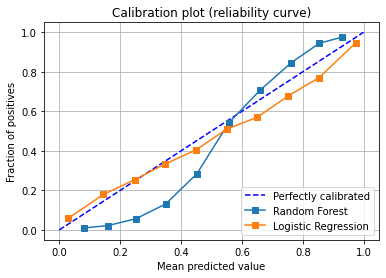

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_rfc = model_rfc.predict_proba(X_test)[:, 1]
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label="%s" % ('Random Forest'))

prob_pos_lr = model_lr.predict_proba(X_test)[:, 1]
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, prob_pos_lr, n_bins=10)
ax.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", label="%s" % ('Logistic Regression'))

ax.legend(loc="lower right")
plt.grid()
fig.savefig('02_rf_lr.png', tight=True, quality=100)

The plot above is commonly referred to as the **calibration plot or reliability diagram (or curve).** In our example, it contains calibration curves for the random forest and logistic regression classifiers, as well as the diagonal dotted line that represents the perfectly calibrated model.

On the x-axis, is the mean predicted value for each bin, and on the y-axis is the fraction of positives.

The random forest has its typical sigmoid shape;the RFC is overconfident in its prediction, pushing the probability toward zero and one. Logistic regression on the other hand usually returns a well calibrated prediction. Therefore, it is usually plotted together with other methods even if it is not directly in use.


**Note: When a model goes below the diagonal, the model is over-forecasting. Above the diagonal, the model is under-forecasting.**

Now, we have a visual representation of the calibration curves, but how can we decide which model is better calibrated? For this we need the Brier Score!

----

Brier score RFC: 0.12
Brier score LR: 0.16


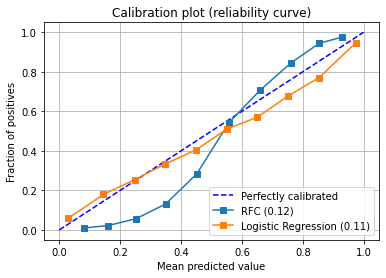

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

model_rfc_score = brier_score_loss(y_test, y_pred_rfc, pos_label=y.max())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_rfc, n_bins=10)

ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%0.2f)" % ('RFC', model_rfc_score))
print("Brier score RFC: %0.2f" % brier_score_loss(y_test, y_pred_rfc))


model_lr_score = brier_score_loss(y_test, prob_pos_lr, pos_label=y.max())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_lr, n_bins=10)

ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%0.2f)" % ('Logistic Regression', model_lr_score))
print("Brier score LR: %0.2f" % brier_score_loss(y_test, y_pred_lr))

ax.legend(loc="lower right")
plt.grid()
fig.savefig('03_rf_lr.png', tight=True, quality=100)


The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome. The Brier score always takes on a value between zero and one, since this is the largest possible difference between a predicted probability (which must be between zero and one) and the actual outcome (which can take on values of only 0 and 1). It can be decomposed is the sum of refinement loss and calibration loss.

The Brier score is appropriate for binary and categorical outcomes that can be structured as true or false, but is inappropriate for ordinal variables which can take on three or more values (this is because the Brier score assumes that all possible outcomes are equivalently “distant” from one another). Which label is considered to be the positive label is controlled via the parameter pos_label, which defaults to the greater label unless y_true is all 0 or all -1, in which case pos_label defaults to 1.

-----


### Probability calibration
The probability calibration of a model is a re-scaling of the model, it can be done using the scikit function CalibratedClassifierCV

There are two arguments of the function we have to consider: the methods and the validations:

### Two methods of calibration:
- **Sigmoid scaling or Platt’s method:** This is suitable for models with a sigmoid curve (like RFC) and it works well with small datasets.
- **Isotonic regression — a non-parametric approach:** It is a more powerful calibration method but it tends to overfit and is not advised for small datasets.

F1: 0.88
F1: 0.88
F1: 0.88


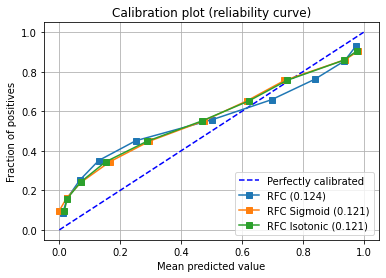

In [17]:
def get_calibration_curve_values(model, X_train, y_train, X_test, y_test): 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prob_pos = model.predict_proba(X_test)[:, 1]
    model_score = brier_score_loss(y_test, y_pred, pos_label=y.max())
    
    print("F1: %0.2f" % f1_score(y_test, y_pred))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    return(fraction_of_positives, mean_predicted_value, model_score)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

model_rfc = RandomForestClassifier()
mpv, fp, score = get_calibration_curve_values(model_rfc, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC', score))

calibrator_sigmoid = CalibratedClassifierCV(RandomForestClassifier(), cv=5, method='sigmoid')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC Sigmoid', score))

calibrator_isotonic = CalibratedClassifierCV(RandomForestClassifier(), cv=5, method='isotonic')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC Isotonic', score))

ax.legend(loc="lower right")
plt.grid()
fig.savefig('04_before.png', tight=True, quality=100)
# F1: 0.89
# F1: 0.88
# F1: 0.88
